In [1]:
# Import required libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


In [2]:
# Importing the Data                                                                       Shape

Endg_Truth = loadmat('end6_groundTruth.mat')      
Ground_Truth = loadmat('groundTruth.mat')               
Urban = loadmat('Urban_R162.mat')                 
image = Urban['Y'].T                                                                #               94249*162  
groundTruth = Ground_Truth ['groundTruth']                                          #               307*307
image_shape = (Ground_Truth ['nRow'], Ground_Truth ['nCol'], image.shape[1])


def hyper_to_2D(img):
    """
    
    Converts a 3D HSI cube (m x n x p) to a 2D matrix of points (N X p)
+   N = m*n, p := number of bands

    """
    img = np.array(img)
    ndim = img.ndim

    if ndim not in [2, 3]:
      raise "invalid dimention. ndim = 2 or 3"

    if ndim == 2:
      m, n = np.shape(img)
      
      hyper_img = np.empty((m,n,1))
      hyper_img[:,:,0] = img

      return hyper_to_2D(hyper_img).ravel()

    m, n, p = np.shape(img)
    N = n * m
    
    dataset = img.T.reshape((p, N)).T

    if p == 1:
      return dataset.ravel()
    
    return dataset

image = image
groundTruth = hyper_to_2D(groundTruth)

print(image.shape)
print(groundTruth.shape)


(94249, 162)
(94249,)


In [3]:
# Standardization
# Split into train (2/3) and test (1/3) sets

image = StandardScaler().fit_transform(image)
seed = 40
X_train, X_test, y_train, y_test = train_test_split(image, groundTruth, test_size = 0.30 , train_size = 0.70 , random_state = seed , stratify=groundTruth)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(65974, 162)
(28275, 162)
(65974,)
(28275,)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:  3.8min finished

[2022-02-06 11:17:38] Features: 1/10 -- score: 0.5298143867913826[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 161 out of 161 | elapsed:  3.3min finished

[2022-02-06 11:20:53] Features: 2/10 -- score: 0.7679693084510321[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  3.4min finished

[2022-02-06 11:24:16] Features: 3/10 -- score: 0.8977627916923208[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

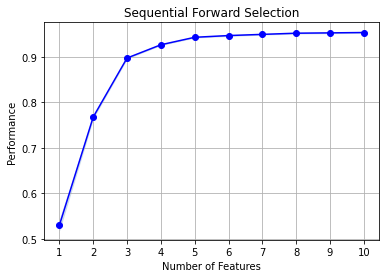

In [5]:
# Build step forward feature selection

from sklearn.neighbors import KNeighborsClassifier
sfs = SFS(KNeighborsClassifier(n_neighbors=3),
           k_features=10, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',  # sklearn classifiers
           cv=5)

# Perform SFFS

sfs = sfs.fit(X_train, y_train)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

In [7]:
# Which features?

SFS_FS = list(sfs.k_feature_idx_)
print(SFS_FS)


[14, 47, 61, 76, 106, 107, 115, 129, 142, 145]


In [8]:
# Build full model with selected features

for k in range(1,10):
    Model = KNeighborsClassifier(n_neighbors=k)
    Model.fit(X_train[:, SFS_FS], y_train)
    predict = Model.predict(X_test[:, SFS_FS])
    acc_train = Model.score(X_train[:, SFS_FS], y_train)
    acc_test = Model.score(X_test[:, SFS_FS], y_test)
    print(f'number {k} ', acc_train , acc_test)
    
    

number 1  1.0 0.9497789566755084
number 2  0.9760814866462546 0.946631299734748
number 3  0.9785673143965805 0.9550486295313881
number 4  0.9728984145269348 0.9529973474801061
number 5  0.972170855185376 0.9572413793103448
number 6  0.9699881771606996 0.9563572060123784
number 7  0.9691848303877285 0.9573474801061008
number 8  0.9677600266771759 0.9569938107869143
number 9  0.9670173098493345 0.9571352785145889


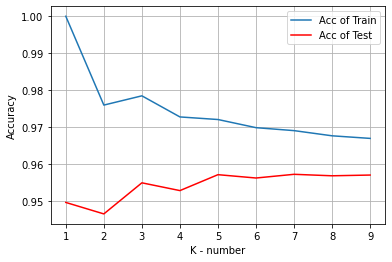

In [9]:

x1 = np.array([1, 2,3,4,5,6,7,8,9])
y1 = np.array([1.0, 0.9760 ,0.9785 , 0.9728 ,0.9721 ,0.9699 ,0.9691,0.9677 ,0.9670 ])
x2 = np.array([1, 2,3,4,5,6,7,8,9])
y2 = np.array([ 0.9497,0.9466, 0.9550 ,0.9529 ,0.9572,0.9563 ,0.9573 , 0.9569, 0.9571])
plt.plot(x1, y1, x2, y2,'r')

plt.xlabel('K - number')
plt.ylabel('Accuracy')
plt.legend(['Acc of Train', 'Acc of Test']);
plt.grid()
plt.show()